<a href="https://colab.research.google.com/github/YuvalKnaz/StopDetection/blob/main/Stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

קובץ התקנה ואימפורטים- להריץ פעם אחת


In [ ]:
!pip install ultralytics opencv-python numpy

#חיבור לדרייב
from google.colab import drive
drive.mount('/content/drive')

#imports
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00
Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


הקוד המוכן


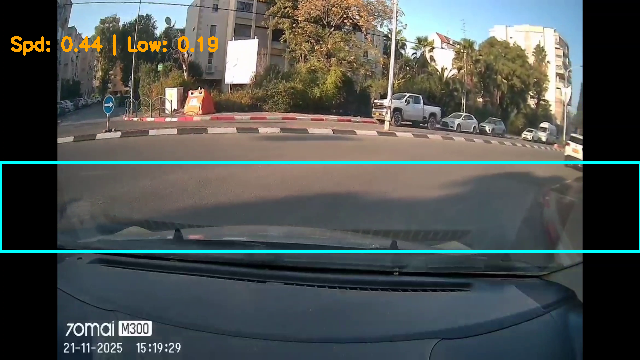

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 זוהתה עבירה! אין עצירה.


In [ ]:
# המודל אחרי אימון ברובופלואו
model_path = '/content/drive/MyDrive/המודל_שלי_מוכן/best.pt'

#טעינת המודל
model = YOLO(model_path)

#נתיב הסרטון לבדיקה
video_path = '/content/drive/MyDrive/סמינריון סרטונים/גדול-לא9.mp4'

#  פרמטרים קבועים
SOFT_SPEED_THRESHOLD = 0.35
MIN_STOP_FRAMES = 30
HARD_STOP_THRESHOLD = 0.06
SCANNING_SKIP = 3
TRACKING_SKIP = 1
DISPLAY_SKIP = 4

#חותך את הסרטון לפריימים
cap = cv2.VideoCapture(video_path)
#הגדרות להורדת הסרטון בסוף
output_filename = 'output_file.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_filename, fourcc, 30, (640, 360))

#משתנים
prev_gray = None
stop_counter = 0
did_stop = False
violation_alert = False
is_tracking_mode = False
ever_saw_sign = False
frames_since_last_sign = 0
frame_total_count = 0
lowest_speed_in_sequence = 100.0


#לולאה עבור כל פריים בסרטון
while cap.isOpened():
    left, frame = cap.read()
    if not left: #לא נשאר פריימים לבדיקה
        break

    frame_total_count += 1

    #כשמגיעים לתמרור בודקים כל פריים ולא מדלגים על 3 כמו בהתחלה
    if is_tracking_mode:
      current_skip=TRACKING_SKIP
    else:
      current_skip=SCANNING_SKIP
    #כאן מתבצע הדילוג במידה ולא רוצים לבדוק את הפריים שהגענו אליו
    if frame_total_count % current_skip != 0:
        continue
    #שינוי גודל הפריים שיהיה קל יותר לעיבוד
    display_frame = cv2.resize(frame, (640, 360))

    # זיהוי תמרור ובמידה וראינו אחד אז להמשיך לחפש שוב ביולו רק עוד 3 פריימים כדי לחסוך בעיבוד
    run_yolo = True
    if is_tracking_mode and frame_total_count % 3 != 0:
        run_yolo = False

    sign_in_frame = False

    if run_yolo:
        #שולח לבדיקה ביולו ומחזיר את הריבוע עם התמרור במרכז
        results = model.predict(display_frame, conf=0.4, verbose=False)
        #אם באמת קיים ריבוע כזה אז חייב להיות תמרור
        if len(results[0].boxes) > 0:
            sign_in_frame = True
            ever_saw_sign = True
            #בשביל בדיקה מתי עברנו את התמרור
            frames_since_last_sign = 0
            #אם זה פעם ראשונה שראית תמרור בסרטון הזה
            if not is_tracking_mode:
                is_tracking_mode = True
                #איפוס האופטיק פלו
                prev_gray = None
                # איפוסים של תחילת מעקב
                stop_counter = 0
                lowest_speed_in_sequence = 100.0


            for box in results[0].boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                # ציור ריבוע סגול על התמרור
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), (255, 0, 255), 2)

        #אם כן בודקים ביולו אבל לא מצאנו תמרור
        else:
            if is_tracking_mode:
                frames_since_last_sign += 1


    # איפוס המהירות לאופטיקל פלו
    current_speed = 99.0
    #אם צריך לבדוק אז ממירים את התמונה לגווני אפור בשביל האופטיקל פלו
    if is_tracking_mode:
        gray = cv2.cvtColor(display_frame, cv2.COLOR_BGR2GRAY)
        height, width = gray.shape

        # הגדרת האזור לבדיקה
        roi_top = int(height * 0.45)
        roi_bottom = int(height * 0.70)
        roi_gray = gray[roi_top:roi_bottom, :]

        # ככה הריבוע תמיד יצוייר כשבודקים
        cv2.rectangle(display_frame, (0, roi_top), (width, roi_bottom), (255, 255, 0), 2)

        #אם יש פריים קודם אז אפשר להשוות אותו עם הנוכחי באופטיקל פלו
        if prev_gray is not None:
          #ההשוואה עצמה
            flow = cv2.calcOpticalFlowFarneback(
                prev_gray, roi_gray, None,
                pyr_scale=0.5, levels=3, winsize=15,
                iterations=3, poly_n=5, poly_sigma=1.2, flags=0
            )
            #חישוב המהירות
            change, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            current_speed = np.mean(change)


            # עדכון השיא של מהירות נמוכה
            if current_speed < lowest_speed_in_sequence:
                lowest_speed_in_sequence = current_speed

            #מונה רצף של מהירות נמוכה
            if current_speed < SOFT_SPEED_THRESHOLD:
                stop_counter += 1
            else:
                stop_counter = 0

            # ההחלטה עצמה האם יש עצירה
            if stop_counter > MIN_STOP_FRAMES:
                if lowest_speed_in_sequence < HARD_STOP_THRESHOLD:
                    did_stop = True
                    violation_alert = False

            #ההחלטה עצמה אם יש עבירה
            if not sign_in_frame and frames_since_last_sign > 80 and not did_stop:
                violation_alert = True
        else:
            current_speed = 99.0
        #מתקדם הלאה
        prev_gray = roi_gray.copy()

        #הצגת המהירות
        status = f"Spd: {current_speed:.2f} | Low: {lowest_speed_in_sequence:.2f}"
        color = (0, 165, 255)
        cv2.putText(display_frame, status, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


    # שמירת הפריים לסרטון ההורדה
    out.write(display_frame)

    # התצוגה רק כל 4 פריימים ליעילות
    if (frame_total_count % DISPLAY_SKIP == 0) or did_stop or violation_alert:
        clear_output(wait=True)
        cv2_imshow(display_frame)

    #יציאה מהלולאה אם יש החלטה
    if did_stop or violation_alert :
        break

cap.release()
out.release()
files.download(output_filename)

#הדפסת ההחלטה
if did_stop :
    print("\n Legal Stop Detected")
elif ever_saw_sign:
    print("\n Violation Detected")
elif not ever_saw_sign:
    print("\n Never Saw Sign")

הפעלת המודל שאומן ב Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Rupj3JQudLNziq8PevuQ")
project = rf.workspace("stop-sign-7qaoh").project("israel-stop-sign-kyu02")
version = project.version(2)
dataset = version.download("yolov8")


In [ ]:

!pip install ultralytics -q

from ultralytics import YOLO
import os
import glob

print("--- מתחילים בהכנות לאימון ---")

yaml_files = glob.glob("*/data.yaml")

if len(yaml_files) == 0:
    print("שגיאה: לא מצאתי את קובץ ההגדרות. האם הרצת את הקוד של Roboflow בהצלחה?")
else:
    dataset_location = os.path.abspath(yaml_files[0])
    print(f"הנתונים נמצאו במיקום: {dataset_location}")


    model = YOLO('yolov8n.pt')

    print("--- מתחילים את האימון! זה ייקח בין 10 ל-20 דקות... ---")


    model.train(data=dataset_location, epochs=50, imgsz=640, name='my_stop_sign_model')

שמירת המודל לדרייב


In [ ]:
import shutil
import os
from google.colab import drive

print("--- מתחיל בשמירת המודל לתיקייה נפרדת ---")


drive.mount('/content/drive')

source_path = '/content/runs/detect/my_stop_sign_model/weights/best.pt'

new_folder_name = 'המודל_שלי_מוכן'
destination_folder = f'/content/drive/MyDrive/{new_folder_name}'
destination_file = f'{destination_folder}/best.pt'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    print(f"✅ יצרתי עבורך תיקייה חדשה בדרייב בשם: {new_folder_name}")
else:
    print(f"ℹ️ התיקייה {new_folder_name} כבר קיימת, אשמור בתוכה.")

if os.path.exists(source_path):
    shutil.copy(source_path, destination_file)
    print("\n" + "="*50)
    print("✅ הצלחה! המודל נשמר בנפרד.")
    print(f"המיקום החדש: {destination_file}")
    print("="*50)
else:
    print("❌ שגיאה: לא מצאתי את קובץ המודל בקולאב. האם האימון הסתיים?")